# **Network Dynamics: Homework II**
## Andrea Silvi (s290312), Politecnico di Torino
## andrea.silvi@studenti.polito.it

**Note**: I have shared ideas of how to solve this homework with classmates Rizzardi Andrea (s287396), Tatti Fabio (s282383), Turco Maria Francesca (s278427).






In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Problem 1

In [ ]:
Lambda = np.array([[0, 2/5, 1/5, 0, 0], [0, 0, 3/4, 1/4, 0], [1/2, 0, 0, 1/2, 0],
                   [0, 0, 1/3, 0, 2/3], [0, 1/3, 0, 1/3, 0]])

## 1.a, b) 
We simulate for 100000 steps the process starting from $a$, counting how many times it visits node $a$ and we divide the total time of the process (up to the last visit to $a$) by this counter to get the average time. We then use Kac's formula to compute the theoretical return time.
\begin{equation}
\mathbb{E}_a[T_a^+] = \frac{1}{\omega_a \overline{\pi}_a}
\end{equation}

In [ ]:
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

In [ ]:
# set the number of steps in the simulation
n_steps = 1000000
n_states = len(w)

pos = np.zeros(n_steps, dtype=int)
# we start from state 1 (a)
pos[0] = 1
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
t_next = -np.log(np.random.rand())/w[1]
transition_times[0] = t_next
counter = 0 #we will count how many time we get to a

for i in range(1,n_steps):
    pos[i] = np.random.choice(np.arange(n_states), p = P[pos[i-1]]) #choose 1 state randomly with prob. distribution equal to the row of the current state (pos[i-1]) of matrix P
    
    if pos[i] == 1: #we got back to a!
      counter += 1  
      last_visited = i #in order to keep the last ever time we get to a
    t_next = -np.log(np.random.rand())/w[pos[i]]
    transition_times[i] = transition_times[i-1] + t_next

avg_return_time = transition_times[last_visited-1]/counter  #we get the mean
print(avg_return_time)

6.753319541062058


In [ ]:
w_star = np.max(w)
P_bar = Lambda/w_star 
# add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar, axis=1))

values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [ ]:
return_time = 1/(pi_bar[1]*w[1])  #we use Kac's formula to calculate the return time to a
print(return_time)

6.75


## 1.c, d)

We simulate the process 1000000 times starting from $o$ and stopping it each time it reaches $d$. We sum each of these times and divide it by the n. of simulations in order to get an estimate of the hitting time from a to d. 
We then obtain from theory the hitting time 
\begin{equation}
    v_o = \mathbb{E}_o[T_d] = \frac{1}{\omega_o} + \sum_{j \in \mathcal{Q}} \hat{P}_{oj} \mathbb{E}_j[T_d],
\end{equation}
by solving the linear system
\begin{equation}
   (\mathbb{I} - \hat{P})v = \frac{\mathbb{1}}{\hat{\omega}}.
\end{equation}

In [ ]:
n_sims = 1000000
total_time = 0
for i in range(n_sims):
  prev_pos = 0
  next_pos = 0
  while next_pos != 4: #simulate 1 run until we reach node 4 (d)
    prev_pos = next_pos
    t_next = -np.log(np.random.rand())/w[prev_pos] 
    next_pos = np.random.choice(np.arange(n_states), p = P[prev_pos])
    total_time += t_next

print(total_time/n_sims)

8.781421585348351


In [ ]:
hatP = P[:-1, :-1]  #restrict matrix P to all nodes except d
hatx = np.linalg.solve(np.identity(n_states-1)-hatP,np.ones(n_states-1)/w[:-1]) #we solve the linear system reported above.
print(hatx[0])

8.785714285714285


## 1.e)

We simulate the French-DeGroot dynamics over the graph used already above with a chosen initial condition, and we confront the result of the simulation with the consensus value it should converge to ($\pi'x(0)$).


In [ ]:
x = x0 = [1, 0, 0.3, 0.7, 0.18]
for n in range(100000):
    x = P @ x #simulate the FDG dynamics.
print(x)


[0.4226087 0.4226087 0.4226087 0.4226087 0.4226087]


In [ ]:
w,v = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(n_states) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi)
    print("pi =", pi)

pi = [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]


In [ ]:
pi@x0 #the consensus value the dynamics should converge to.

0.42260869565217385

## 1.f) 
We simulate what the effect of noisy initial conditions of a real value \mu is on the consensus value the dynamics converges to. 

We define the initial state of each node $i$ as 
\begin{equation}
x_i(0) = \mu + \eta_i,
\end{equation}
where $\eta_i \sim \mathcal{N}(0,\sigma^{2})$ is the error of node $i$.

We compute the estimator of the variance using 1000 simulations of this dynamics (each 500 steps long).

We then compare this result to the theoretical variance of the crowd which, from the calculations done in the report, is
\begin{equation}
\sigma^2_q = \sigma^2 \sum_{i \in \mathcal{G}}\pi_i^2.
\end{equation}

In [ ]:
sigma = np.sqrt(0.2) #we choose sigma^2 = 0.2
mu = 1/2  #the true hidden value
errors = np.zeros(1000)
for i in range(1000): #we simulate 1000 times
  x = mu + np.random.normal(0, sigma, 5)  #define the initial condition for each of the 5 states.
  for j in range(500):  #simulate each run for 500 steps.
    x = P@x
  errors[i] = (np.mean(x) - mu)*(np.mean(x) - mu) #we get the squared errors between the value it converged to and the real hidden value mu.

print("variance of the single agents: ", sigma*sigma) #in order to see if the variance of the crowd is actually lower
print("variance of the crowd: ", np.mean(errors)) #estimator of the variance

variance of the single agents:  0.19999999999999998
variance of the crowd:  0.04298026153142637


In [ ]:
print('theoretical variance of the crowd:', pi@pi*(sigma*sigma))

theoretical variance of the crowd: 0.04272211720226843


## 1.g)

We remove edges $(d,a)$ and $(d,c)$ and redo the calculations of the previous points.

In [ ]:
Lambda_2 = Lambda.copy()
Lambda_2[4,1] = Lambda_2[4,3] = 0
Lambda_2[4,4] = 1 #self loop needed for matrix P
w = np.sum(Lambda_2, axis=1)
D = np.diag(w)
P_2 = np.linalg.inv(D) @ Lambda_2

In [ ]:
x = x0 = [1, 0.8, 0.3, 0.7, 0.85]
for n in range(100000):
    x = P_2 @ x
print(x)

[0.85 0.85 0.85 0.85 0.85]


In [ ]:
sigma = np.sqrt(0.2)
mu = 1/2
errors = np.zeros(1000)
for i in range(1000):
  x = mu + np.random.normal(0, sigma, 5)
  for j in range(500):
    x = P_2@x
  errors[i] = (np.mean(x) - mu)*(np.mean(x) - mu)

print("variance of the single agents: ", sigma*sigma)
print("variance of the crowd: ", np.mean(errors))

variance of the single agents:  0.19999999999999998
variance of the crowd:  0.19923405250451456


In [ ]:
w,v = np.linalg.eig(P_2.T)

#Obviously having 1 sink with 1 single element, the invariant distribuition is only
#defined on that single sink component. We compute it anyway for completeness.

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(n_states) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi)
    print("pi =", pi)

pi = [0. 0. 0. 0. 1.]


In [ ]:
print('theoretical variance of the crowd:', pi@pi*(sigma*sigma))

theoretical variance of the crowd: 0.19999999999999998


## 1.h)

We remove from $\Lambda$ edges $(c,b)$ and $(d,a)$ and see if the system can reach a consensus value.


In [ ]:
Lambda_3 = Lambda.copy()
Lambda_3[3,2] = Lambda_3[4,1] = 0
w = np.sum(Lambda_3, axis=1)
D = np.diag(w)
P_3 = np.linalg.inv(D) @ Lambda_3

In [ ]:
x = x0 = [0.11, 0.99, 0.01, 0.2, 0.8]
for n in range(1000000):
    x = P_3 @ x
print(x)

[0.47692308 0.45384615 0.66153846 0.2        0.8       ]


# Problem 2

## 2.a)
We first simulate a process similar to Problem 1 but with 100 particles starting from node $a$. We want to calculate again the average return time to $a$. We use $1$ global Poisson Clock with rate $100$ to simulate the times, and then sample one particle at random that moves with probability $\overline{P}$.

In [ ]:
P_bar

array([[0.4       , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333]])

In [ ]:
total_time = 0
n_sims = 10000
for sim in range(n_sims):
  start = 1 #the node a where each particle starts and must come back
  positions = np.ones(100, dtype=np.int32)*start #all particles start in node start (a)
  return_times = np.zeros(100) #we store the return time of each particle
  has_moved = np.zeros(100) #used in order to not consider times of particles that have not moved from a
  how_many_back = 0       
  t_sum = 0
  while how_many_back < 100:    #we stop when all of them are back in a!
      t_next = -np.log(np.random.rand())/100    #global poisson clock
      t_sum = t_sum + t_next #keep track of the total time
      i = np.random.randint(0, 100) #choose which particle is potentially moving
      positions[i] = np.random.choice(np.arange(n_states), p = P_bar[positions[i]])
      if has_moved[i] == 0 and positions[i] != start: #if particle i exits node a, then next time it is in a we can store its return time
        has_moved[i] = 1
      if has_moved[i] == 1 and positions[i] == start and return_times[i] == 0:  #has already exited node a and is back for the first time!
        return_times[i] = t_sum
        how_many_back += 1

  avg_return_time = np.average(return_times)  #we take the average of the single run
  total_time = total_time + avg_return_time
print(total_time / n_sims)    #we then average all the runs

6.747368407969481


## 2.b)
We then simulate the same process but with the $100$ particles starting from $o$. 

We want to compare the average number of particles in each node at the end of the simulation (60 units of time long) with the stationary distribution $\overline{\pi}$ of the continuous time random walk of the single particle over the same graph.

We also plot the evolution of the number of particles for each node from one of the runs.

In [ ]:
n_sims = 1000
total_numerosities = np.zeros(5, dtype=np.int32) #used to do the average of all the runs
for sim in range(n_sims): #we simulate the process 10000 times
  start = 0 #the node o where each particle starts
  numerosities = np.zeros(5, dtype=np.int32) #tracks the number of particles in each node at every timestep
  numerosities[start] = 100   #at time 0, 100 particles in node start (o) 
  t_total = 0 
  while t_total<60: #simulate for 60 time steps
    t_next = -np.log(np.random.rand())/100
    t_total += t_next
    chosen_node = np.random.choice(np.arange(n_states), p = numerosities/np.sum(numerosities)) #choose which node to move from proportionally to its number of particles
    next_node = np.random.choice(np.arange(n_states), p = P_bar[chosen_node]) #choose where 1 particle will jump to
    numerosities[chosen_node] -=1 #remove 1 particle from node chosen_node
    numerosities[next_node] +=1 #add the same particle to the next_node
  total_numerosities = total_numerosities + numerosities
print(total_numerosities/n_sims)  



[18.474 14.678 22.278 22.194 22.376]


In [ ]:
#we do another run to plot it.

start = 0
numerosities = np.zeros(5, dtype=np.int32) 
numerosities[start] = 100
t_total = 0 
counter = 0
t_times = np.zeros(10000) #we keep track of the transition times to plot it
numerosities_per_time = np.zeros((5,10000), dtype=np.int32) #we track the number of particles in each node at each transition time
while t_total<60: #simulate for 60 time steps
  numerosities_per_time[:, counter] = numerosities  #save the n. of particles at the counter-th transition
  t_next = -np.log(np.random.rand())/100
  t_total += t_next
  t_times[counter] = t_total  #save the time
  counter += 1
  chosen_node = np.random.choice(np.arange(n_states), p = numerosities/np.sum(numerosities))
  next_node = np.random.choice(np.arange(n_states), p = P_bar[chosen_node])
  numerosities[chosen_node] -=1
  numerosities[next_node] +=1

Text(0, 0.5, 'Number of particles')

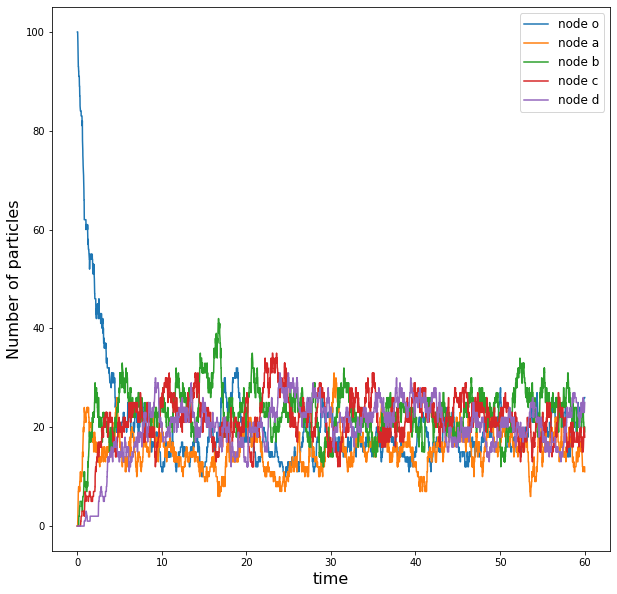

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
node_names = {0: 'o', 1:'a', 2:'b', 3:'c', 4: 'd'}
for i in range(n_states):
  node = 'node ' + str(node_names[i])
  ax.plot(t_times[:counter], numerosities_per_time[i, :counter], label=node)
  ax.legend(loc='best', fancybox=True, frameon=True, fontsize=12)
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Number of particles', fontsize=16) 

In [ ]:
pi_bar

array([0.18518519, 0.14814815, 0.22222222, 0.22222222, 0.22222222])

In [ ]:
print(total_numerosities/n_sims) 

[18.474 14.678 22.278 22.194 22.376]


In [ ]:
print((total_numerosities/n_sims)/np.sum(total_numerosities/n_sims))

[0.18474 0.14678 0.22278 0.22194 0.22376]


# Exercise 3

We define the new open network based on the transition rate matrix $\Lambda_{open}$ and we augment it by adding $1$ more node connected to node $o$. 

In [ ]:
Lambda_open =  np.array([[0, 2/3, 1/3, 0, 0], [0, 0, 1/4, 1/4, 2/4], [0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
#nodes are o, a, b, c, d

In [ ]:
#we add at the start node o_bar at index 0 
Lambda_augmented = np.zeros((n_states+1, n_states+1))
Lambda_augmented[1:, 1:] = Lambda_open  #the augmented Lambda is equal to the previous one if restricted on {o,a,b,c,d}
Lambda_augmented[0, 1] = 1 #can move from o_bar only to o

In [ ]:
w = np.sum(Lambda_augmented, axis=1)
w_star = np.max(w)
P_bar = Lambda_augmented/w_star 
# add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar, axis=1)) #calculate the new P_bar

In [ ]:
P_bar

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.66666667, 0.33333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.25      , 0.25      ,
        0.5       ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

We define a function $cycle$(input_rate, fixed_nodes_rates) that is able to simulate the system with nodes rate that are both proportional to the number of particles inside them (fixed_nodes_rates = *False*) and fixed at $1$ (fixed_nodes_rates = *True*). 

We simulate for 60 time units using $1$ single Poisson Clock (full details are given in the report) and we plot results with different values of input_rate.

In [ ]:
def cycle(input_rate, fixed_nodes_rates):
  if fixed_nodes_rates: #rates will be fixed for the entire simulation.
    rates = np.array([input_rate, 1, 1, 1, 1, 1])
  start = 0 #we consider a fake node o_bar outside of o, it will always have 1 particle
  numerosities = np.zeros(6, dtype=np.int32) #counts number of particles in each node of the system
  t_total = 0 
  counter = 0 #counts how many jumps, useful for the plot
  t_times = []  #saves the entire time of jumps trajectory
  numerosities_per_time = [[],[],[],[],[]]  #saves the entire trajectories of n. of particles per node (in the system)
  total_particles = 0 #the n. of total particles in the system, useful for poisson clock rate (in proportional simulation)
  numerosities[0] = input_rate #so the distribution of chosen_node in 0 can be proportional to the input rate (note: this never changes during the simulation!)
  while t_total<60: #simulate for 60 time steps
    for i in range(1, n_states+1):
      numerosities_per_time[i-1].append(numerosities[i])
    if not fixed_nodes_rates: #node rates proportional to n. of particles in them.
      global_rate = total_particles*1 + input_rate  #global rate is the sum of the particles in the system + the input_rate (note: changes with how many particles are in the system!)
      p_distr = numerosities/np.sum(numerosities)   #we choose the node the particle jumps from randomly proportionally to # particles in nodes (in the system, note that numerosities[0] is always = input rate!)
    else: #node rates are fixed to 1.
      #we count which nodes of the system have AT LEAST 1 particle
      mask_inactive_nodes = np.array([1 if numerosities[i] > 0 else 0 for i in range(1, n_states+1)]) 
      n_active_states = np.sum(mask_inactive_nodes) #number of nodes in the system that have AT LEAST 1 particle
      global_rate = n_active_states*1 + input_rate #only the rates of active nodes come into play! (+ the fake node o_bar outside o)
      p_distr = rates.copy()
      #we need to mask with 0 those states that do not have any particles so we do not choose them
      p_distr[1:] = p_distr[1:]*mask_inactive_nodes
      p_distr = p_distr/np.sum(p_distr)
      
    t_next = -np.log(np.random.rand())/(global_rate)  #find the new jump time
    t_total += t_next
    t_times.append(t_total)
    counter += 1
    chosen_node = np.random.choice(np.arange(0, n_states+1), p = p_distr) #choose which node to move from proportionally to p_distr calculated above
    next_node = np.random.choice(np.arange(0, n_states+1), p = P_bar[chosen_node]) #choose where 1 particle will jump to accordingly to P_bar
    if chosen_node == 0 and next_node != 0: #new particle in system!
      total_particles += 1  #add 1 particle to total n. of particles in the system
      numerosities[next_node] += 1
    elif chosen_node == 5: #d has been chosen, a particle exits the system (note that since rate_d = omega_max = 1, P_bar[d,d]=0 so everytime d is choosen the particle exits the system.)
      total_particles -= 1
      numerosities[chosen_node] -= 1
    else: #for all the other nodes
      numerosities[chosen_node] -= 1
      numerosities[next_node] += 1
  return numerosities_per_time, t_times, counter

In [ ]:
def printGraph(numerosities_per_time, t_times, counter, input_rate, total_time):
  node_names = {0: 'o', 1:'a', 2:'b', 3:'c', 4: 'd'}
  fig, ax = plt.subplots(figsize=(10,10))
  for i in range(n_states): #we do not care about o_bar obviously
    node = 'node ' + str(node_names[i])
    ax.plot(t_times[:counter], numerosities_per_time[i][:counter], label=node)
    ax.legend(loc='best', fancybox=True, frameon=True, fontsize=12)
  ax.set_xlabel('time', fontsize=16)
  ax.set_ylabel('Number of particles', fontsize=16) 
  ax.set_title('simulation with input rate '+ str(input_rate) + ' (total time of simulation: ' + str(round(total_time, 3)) +' s)')

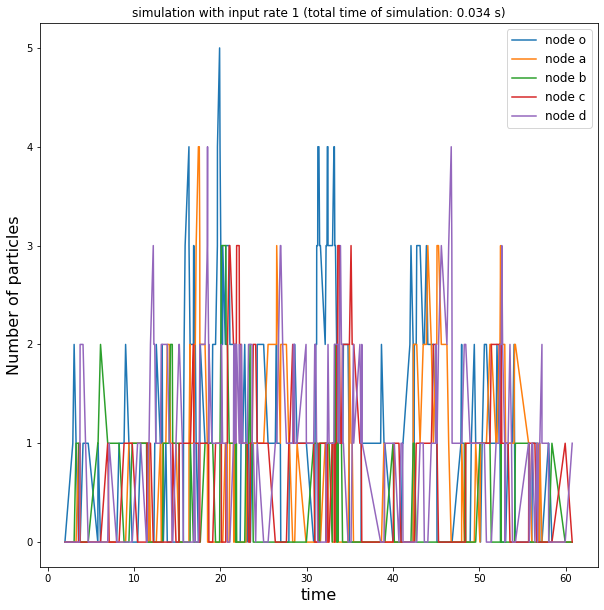

In [ ]:
start = timer()
numerosities_per_time, t_times, counter = cycle(input_rate=1, fixed_nodes_rates = False)
stop = timer()
printGraph(numerosities_per_time, t_times, counter, input_rate=1, total_time = (stop-start))

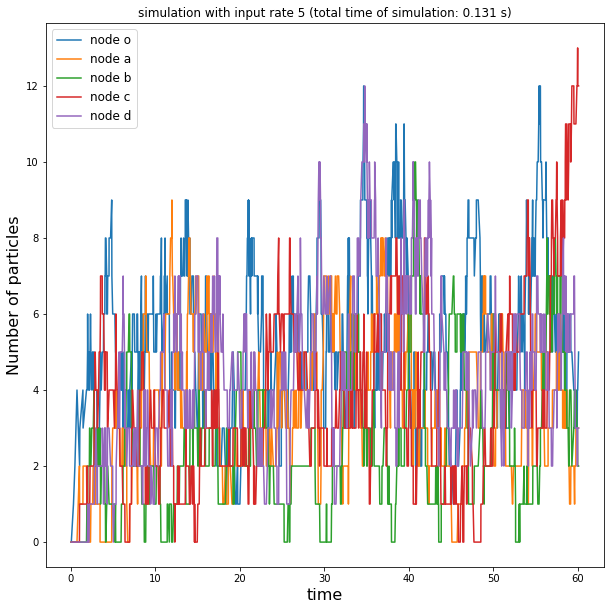

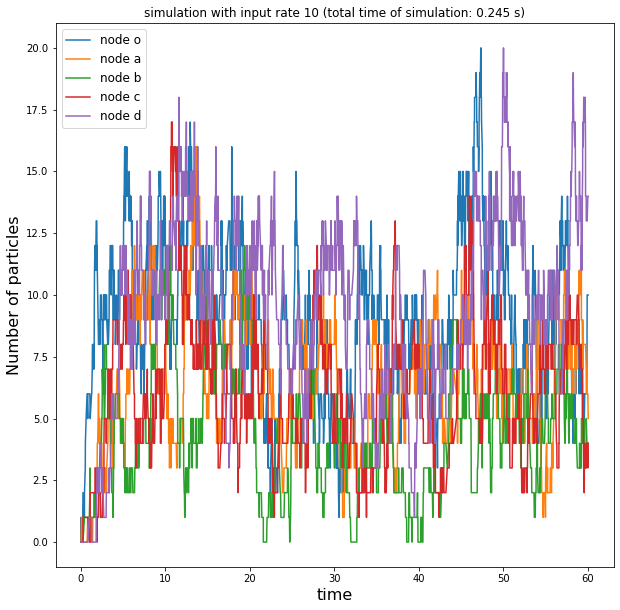

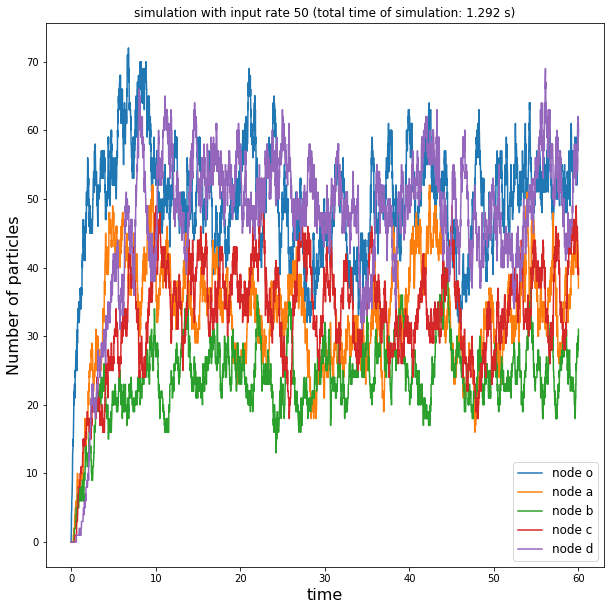

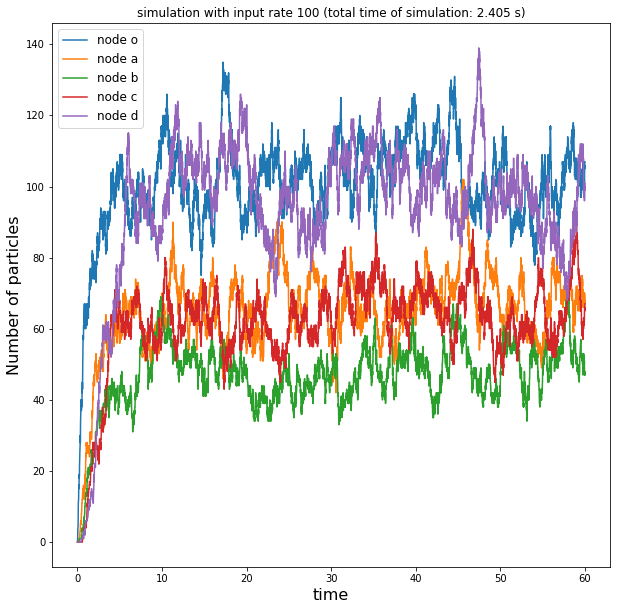

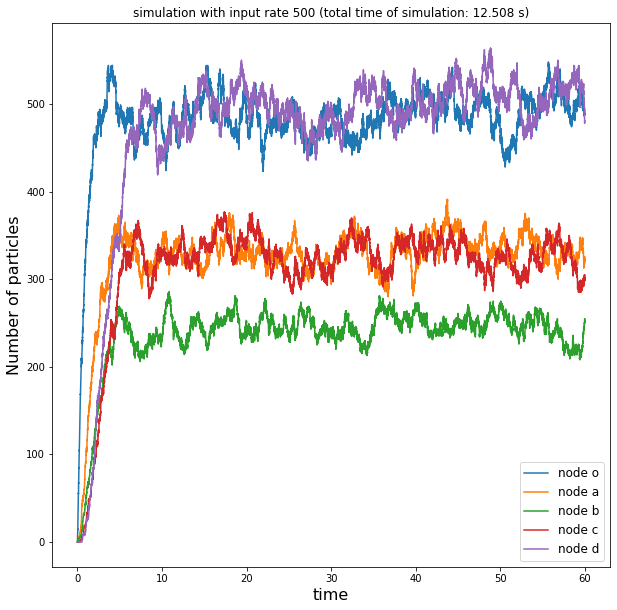

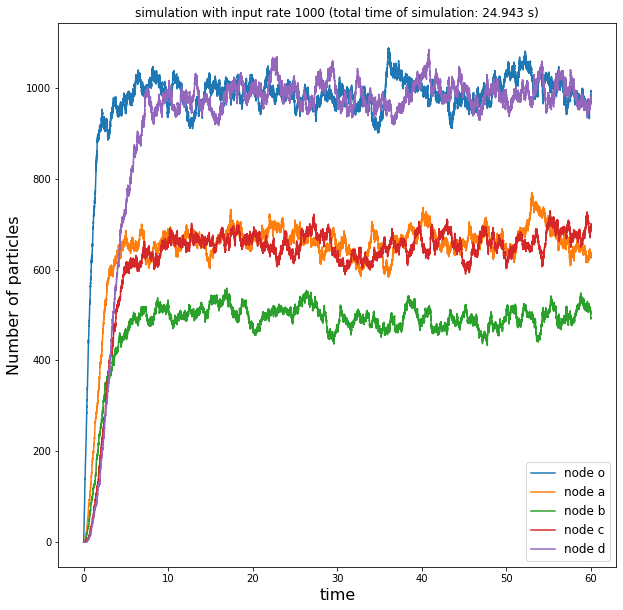

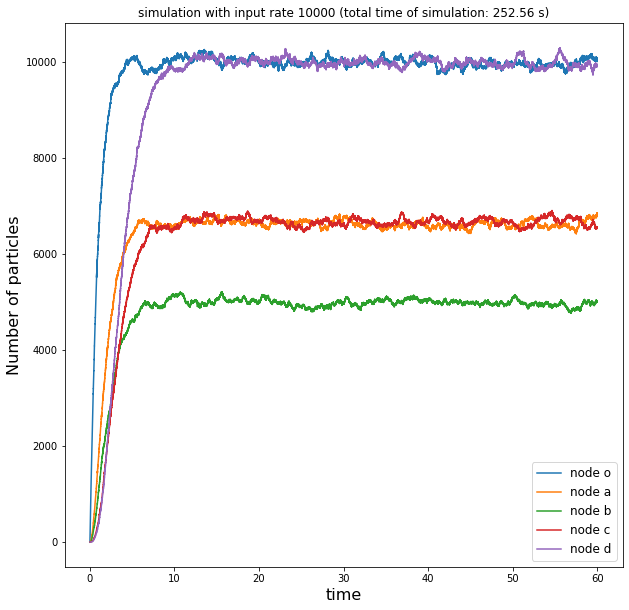

In [ ]:
for l in [5, 10, 50, 100, 500, 1000, 10000]:
  start = timer()
  numerosities_per_time, t_times, counter = cycle(input_rate=l, fixed_nodes_rates = False)
  stop = timer()
  printGraph(numerosities_per_time, t_times, counter, l, (stop-start))

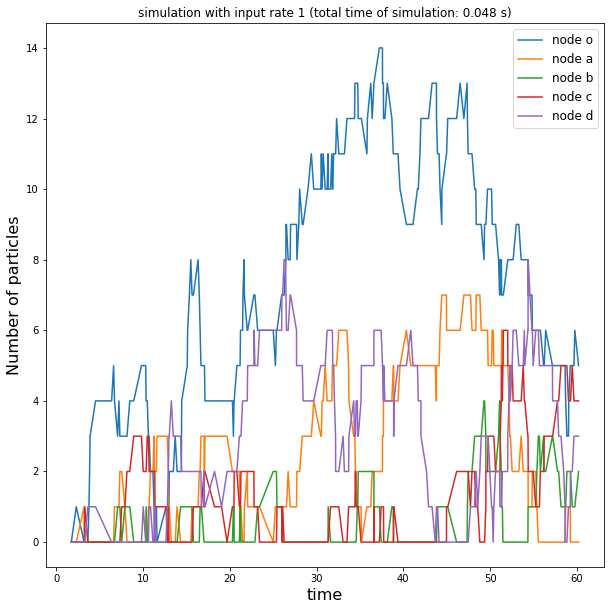

In [ ]:
start = timer()
numerosities_per_time, t_times, counter = cycle(input_rate=1, fixed_nodes_rates = True)
stop = timer()
printGraph(numerosities_per_time, t_times, counter, 1, (stop-start))

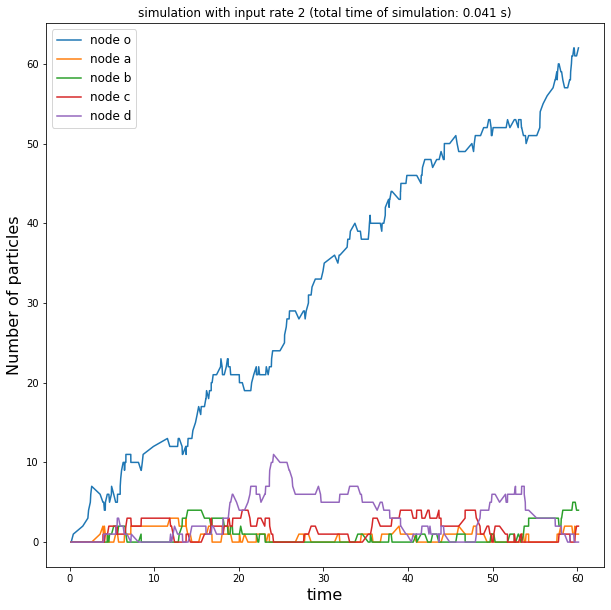

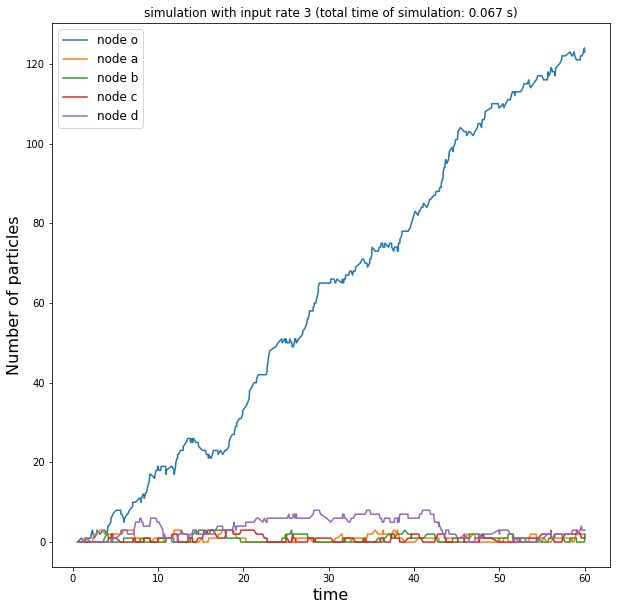

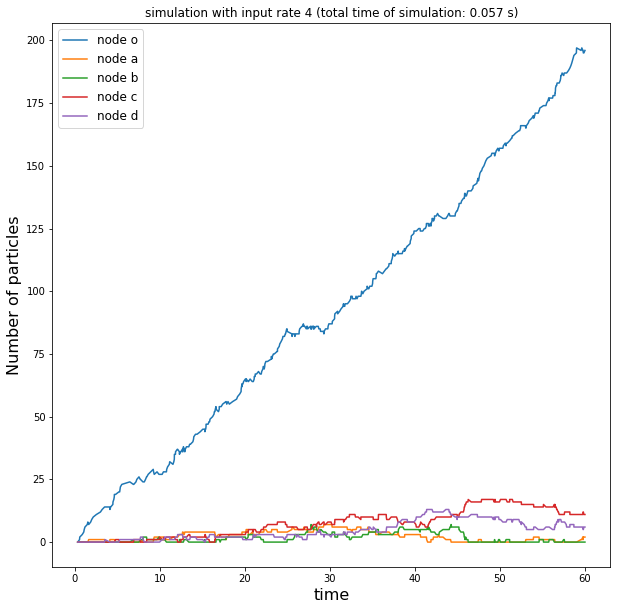

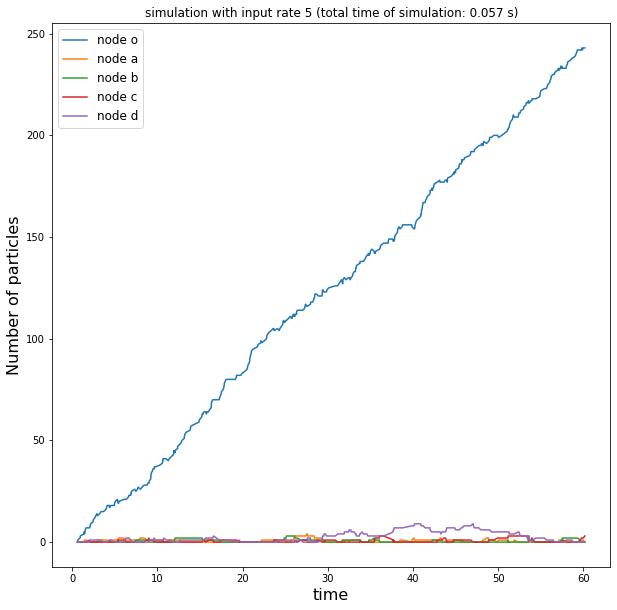

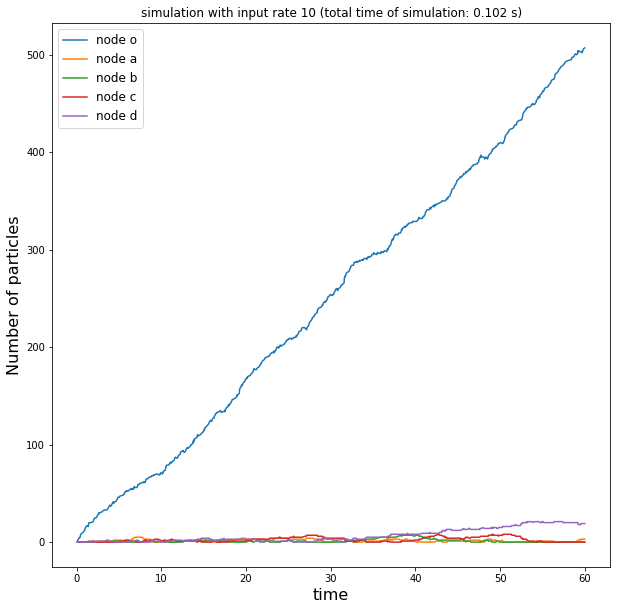

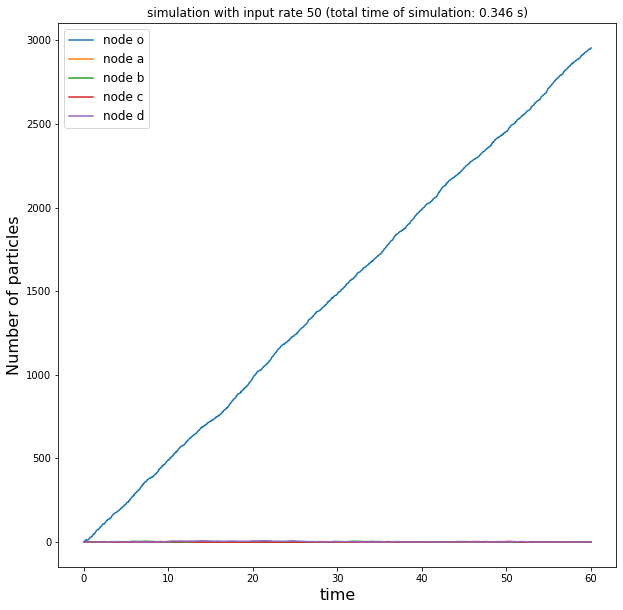

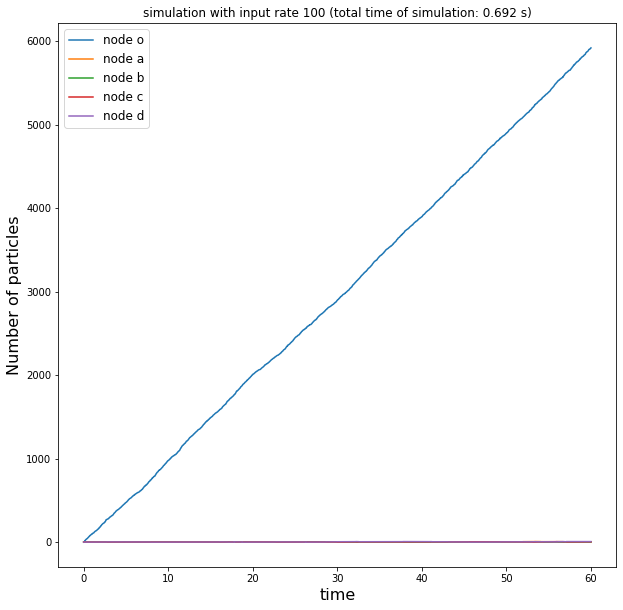

In [ ]:
for l in [2, 3, 4, 5, 10, 50, 100]:
  start = timer()
  numerosities_per_time, t_times, counter = cycle(input_rate=l, fixed_nodes_rates = True)
  stop = timer()
  printGraph(numerosities_per_time, t_times, counter, l, (stop-start))